In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model

# Data Should not contain other date fields

In [3]:
data = pd.read_csv('C:/Users/vidheesha/OneDrive/Desktop/Vidheesha/python datasets/sales_dataset.csv')  # should not contain dates in any other features except in date feature
data.head()


,date,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,apparent_temperature,humidity,precip_intensity_max,precip_prob,precip_type,pressure,summary,temperature
0,02-01-2017,12154.00,0.0,121,0,106,26,42,17,6,35.58,0.92,0.0242,0.79,rain,1027.98,rain,39.06
1,03-01-2017,8440.00,0.0,148,0,119,31,31,14,4,41.50,0.94,0.0913,0.77,rain,1000.08,rain,43.19
2,04-01-2017,12927.64,0.0,174,0,131,17,26,5,2,36.81,0.40,0.0176,0.00,none,1002.55,clear-night,42.29
3,05-01-2017,14457.79,0.0,191,0,138,25,28,4,2,27.11,0.48,0.0000,0.00,none,1014.61,cloudy,31.36
4,06-01-2017,15331.97,0.0,200,0,130,16,54,6,3,24.74,0.48,0.0019,0.00,none,1022.80,partly-cloudy-night,29.42


In [ ]:
target = list() # Empty list to store target features
weather_fea = list() #Empty list to store weather features

print("Column names of given data set: ",pd.DataFrame(data.columns, columns = ['column_names']))

num_target = int(input('Number of Target features: '))

#col = data.columns
col = data.columns.tolist()
for j in range(num_target):
    indx = int(input('Enter index number of target features: '))
    print('you have selected', col[indx])
    a = col[indx]
    target.append(a)
target = list(dict.fromkeys(target))
print("The target features are:",target)

num_weather = int(input('Number of weather features: '))
for i in range(num_weather):
    indx = int(input('Enter index number of weather features: '))
    print("you have selected",col[indx])
    a = col[indx]
    weather_fea.append(a)
weather_fea = list(dict.fromkeys(weather_fea))
print("The weather features are:",weather_fea)

Column names of given data set:              column_names
0                   date
1           inside_sales
2          outside_sales
3          inside_covers
4         outside_covers
5        reserved_covers
6          walkin_covers
7        waitlist_covers
8         no_show_covers
9        no_show_parties
10  apparent_temperature
11              humidity
12  precip_intensity_max
13           precip_prob
14           precip_type
15              pressure
16               summary
17           temperature
Number of Target features: 2
Enter index number of target features: 1
you have selected inside_sales
Enter index number of target features: 1
you have selected inside_sales
The target features are: ['inside_sales']


In [4]:
sal_data = data.drop(weather_fea,axis = 1)
sal_data.head()

,date,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties
0,02-01-2017,12154.00,0.0,121,0,106,26,42,17,6
1,03-01-2017,8440.00,0.0,148,0,119,31,31,14,4
2,04-01-2017,12927.64,0.0,174,0,131,17,26,5,2
3,05-01-2017,14457.79,0.0,191,0,138,25,28,4,2
4,06-01-2017,15331.97,0.0,200,0,130,16,54,6,3


In [5]:
Date = pd.DataFrame(data['date']) 

def obj_dtypes(df):
    obj_features = df.select_dtypes(include = 'object').drop('date', axis = 1)

    if len(obj_features.columns) > 0:
        for (columnName, columnData) in obj_features.iteritems():
            if len(pd.unique(data[columnName])) <=20:
                dummy = pd.get_dummies(obj_features[[columnName]])
                df = pd.merge(df,dummy, left_index =True, right_index=True)
            else:
                df = df.drop(columnName, axis = 1)
    df = df.drop(obj_features,axis=1)
    return df

sal = obj_dtypes(sal_data)
if len(weather_fea) > 0:
    data_wet = obj_dtypes(data)

data_wet.head()

,date,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties,...,precip_type_snow,summary_clear-day,summary_clear-night,summary_cloudy,summary_fog,summary_partly-cloudy-day,summary_partly-cloudy-night,summary_rain,summary_sleet,summary_snow
0,02-01-2017,12154.00,0.0,121,0,106,26,42,17,6,...,0,0,0,0,0,0,0,1,0,0
1,03-01-2017,8440.00,0.0,148,0,119,31,31,14,4,...,0,0,0,0,0,0,0,1,0,0
2,04-01-2017,12927.64,0.0,174,0,131,17,26,5,2,...,0,0,1,0,0,0,0,0,0,0
3,05-01-2017,14457.79,0.0,191,0,138,25,28,4,2,...,0,0,0,1,0,0,0,0,0,0
4,06-01-2017,15331.97,0.0,200,0,130,16,54,6,3,...,0,0,0,0,0,0,1,0,0,0


In [6]:
def cor(data):
    z = data.corr()
    return z
z_sal = cor(sal)
if len(weather_fea) > 0:
    z_data_wet = cor(data_wet)

z_sal

,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties
inside_sales,1.000000,0.013506,0.574311,0.006943,0.328591,-0.063872,0.099651,-0.138575,-0.132363
outside_sales,0.013506,1.000000,0.095021,0.989226,0.090089,0.647330,0.768987,0.253871,0.265473
inside_covers,0.574311,0.095021,1.000000,0.096631,0.510465,0.094219,0.250469,-0.000228,0.009509
outside_covers,0.006943,0.989226,0.096631,1.000000,0.067995,0.698523,0.751107,0.292555,0.307607
reserved_covers,0.328591,0.090089,0.510465,0.067995,1.000000,-0.078566,0.110204,-0.210799,-0.201563
walkin_covers,-0.063872,0.647330,0.094219,0.698523,-0.078566,1.000000,0.185650,0.513484,0.531364
waitlist_covers,0.099651,0.768987,0.250469,0.751107,0.110204,0.185650,1.000000,0.075004,0.077964
no_show_covers,-0.138575,0.253871,-0.000228,0.292555,-0.210799,0.513484,0.075004,1.000000,0.957465
no_show_parties,-0.132363,0.265473,0.009509,0.307607,-0.201563,0.531364,0.077964,0.957465,1.000000


In [7]:
def rel_features(z): 
    cor_target = abs(z[target])
    relevent_features = cor_target[cor_target>0.01]
    print(relevent_features)
    x = obj_dtypes(data)
    finaldf = x[relevent_features.index]
    finaldf = pd.merge(Date,finaldf, left_index=True,right_index=True)
    return finaldf
print("Relavent features for sales prediction: ")
finaldf_sal = rel_features(z_sal)

if len(weather_fea) > 0:
    print("Relavent features including weather features for sales prediction: ")
    finaldf_wet = rel_features(z_data_wet)

Relavent features for sales prediction: 
                 inside_sales  inside_covers
inside_sales         1.000000       0.574311
outside_sales        0.013506       0.095021
inside_covers        0.574311       1.000000
outside_covers            NaN       0.096631
reserved_covers      0.328591       0.510465
walkin_covers        0.063872       0.094219
waitlist_covers      0.099651       0.250469
no_show_covers       0.138575            NaN
no_show_parties      0.132363            NaN
Relavent features including weather features for sales prediction: 
                             inside_sales  inside_covers
inside_sales                     1.000000       0.574311
outside_sales                    0.013506       0.095021
inside_covers                    0.574311       1.000000
outside_covers                        NaN       0.096631
reserved_covers                  0.328591       0.510465
walkin_covers                    0.063872       0.094219
waitlist_covers                  0.099651 

In [8]:
finaldf_sal.head()

,date,inside_sales,outside_sales,inside_covers,outside_covers,reserved_covers,walkin_covers,waitlist_covers,no_show_covers,no_show_parties
0,02-01-2017,12154.00,0.0,121,0,106,26,42,17,6
1,03-01-2017,8440.00,0.0,148,0,119,31,31,14,4
2,04-01-2017,12927.64,0.0,174,0,131,17,26,5,2
3,05-01-2017,14457.79,0.0,191,0,138,25,28,4,2
4,06-01-2017,15331.97,0.0,200,0,130,16,54,6,3


In [9]:
def app_temp(df):
    temp_col = df.columns.tolist()
    if (temp_col.count('apparent_temperature') ==1):
        temp_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
        z = temp_enc.fit_transform(df[['apparent_temperature']])  #Should contain a feature callled apparent_temperature 
        tmp_bin = pd.DataFrame(z,index=df.index, columns=['temperature_bin'])
        tmp_bin = tmp_bin.replace({0:'very_cold',
                               1:'cold',
                               2:'warm',
                               3:'hot',
                               4:'very_hot'})
        print(tmp_bin.head())
        tmp_df = pd.get_dummies(tmp_bin)
        df = pd.merge(df,tmp_df, left_index=True,right_index=True)
    return df

finaldf_sal = app_temp(finaldf_sal)
if len(weather_fea) > 0:
    finaldf_wet = app_temp(finaldf_wet)

  temperature_bin
0            cold
1            cold
2            cold
3       very_cold
4       very_cold


In [10]:
def feature_add(df):
    df['date'] = pd.to_datetime(df['date'],errors='coerce')
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.day_name()
    
    tmp_df = pd.get_dummies(df[['day_of_week']])
    df = pd.merge(df,tmp_df,left_index=True, right_index=True)
    df.drop('day_of_week',axis = 1, inplace = True)
    return df
finaldf_sal = feature_add(finaldf_sal)
if len(weather_fea) > 0:
    finaldf_wet = feature_add(finaldf_wet)

In [11]:
def closed_dates(finaldf):
    additional_closed_dates = pd.date_range(finaldf.date.min(),finaldf.date.max()).difference(finaldf.date)
    raw_start_date = finaldf.date.min()
    start_date = pd.to_datetime(raw_start_date).date()
    current_date = pd.to_datetime(finaldf.date.max()).date()
    end_date = (current_date + pd.DateOffset(1)).date()
    cal = calendar()
    closed_dates_sales_zero = finaldf[finaldf[target[0]]==0].index
    finaldf['closed'] = np.where((((finaldf.date.isin(closed_dates_sales_zero)) &
                                  (finaldf.date.isin(cal.holidays(start_date,end_date)))) |
                                  finaldf.date.isin(additional_closed_dates)),1,0)
    finaldf[target[0]] = np.where(finaldf['closed']==1,0, finaldf[target[0]])
    finaldf = finaldf.set_index('date')
    return finaldf

finaldf_sal = closed_dates(finaldf_sal)
finaldf_sal.head()
if len(weather_fea) > 0:
    finaldf_wet = closed_dates(finaldf_wet)

In [12]:
def outliers(finaldf):
    
    finaldf.fillna(0)
    
    upper_limit = finaldf[target[0]].mean() + 3*finaldf[target[0]].std()
    lower_limit = finaldf[target[0]].mean() - 3*finaldf[target[0]].std()
    mean_target = finaldf[target[0]].mean()
    print("The Mean of the target feature is: ",mean_target)
    print("The Upper limit based on Normal distribution is: ",upper_limit)
    print("The Lower limit based on Normal distribution is: ",lower_limit)
    finaldf[(finaldf[target[0]]> upper_limit) | 
            (finaldf[target[0]]< lower_limit)] #finding the outliers
    finaldf[target[0]]=np.where(finaldf[target[0]]>upper_limit,mean_target,
                          np.where(finaldf[target[0]]<lower_limit,mean_target,finaldf[target[0]]))
    print(finaldf[target[0]].describe())
    return finaldf
print("Describing target feature without weather data :")

finaldf_sal = outliers(finaldf_sal)
if len(weather_fea) > 0:
    print("Describing target feature with weather data :")
    finaldf_wet = outliers(finaldf_wet)

Describing target feature without weather data :
The Mean of the target feature is:  14114.72743047832
The Upper limit based on Normal distribution is:  21500.94026376072
The Lower limit based on Normal distribution is:  6728.514597195923
count      899.000000
mean     14079.446818
std       2079.081616
min       8011.000000
25%      12938.065000
50%      14088.950000
75%      15369.075000
max      20422.050000
Name: inside_sales, dtype: float64
Describing target feature with weather data :
The Mean of the target feature is:  14114.72743047832
The Upper limit based on Normal distribution is:  21500.94026376072
The Lower limit based on Normal distribution is:  6728.514597195923
count      899.000000
mean     14079.446818
std       2079.081616
min       8011.000000
25%      12938.065000
50%      14088.950000
75%      15369.075000
max      20422.050000
Name: inside_sales, dtype: float64


In [13]:
def divide_data(data):
    Y = data[target]
    X = data.drop(target,axis=1)
    return X, Y
x_sal, y_sal = divide_data(finaldf_sal)
if len(weather_fea) > 0:
    x_wet, y_wet = divide_data(finaldf_wet)


In [14]:
print(x_sal.shape, y_sal.shape)
if len(weather_fea) > 0:
    print(x_wet.shape, y_sal.shape)



(899, 16) (899, 2)
(899, 40) (899, 2)


In [15]:
def data_split(X,Y):
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, shuffle=False)

    print(f'Train set: {len(x_train)} -> {len(x_train)/len(X)*100:.2f}%')  #test percentage upto 2 decimal points
    print(f'Test set: {len(x_test)} -> {len(x_test)/len(X)*100:.2f}%')
    
    return x_train, y_train, x_test, y_test

In [16]:
def score(alg, x_train, y_train, x_test, y_test):
    y_pred = alg.predict(x_test)
    y_pred = pd.DataFrame(y_pred,index=y_test.index)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    mae= mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error: ', mae)
    print('Root Mean Squared Error: ',rmse)
    tmp_1 = pd.DataFrame(y_test)
    c = tmp_1
    for i in range(len(target)):
        tmp = pd.DataFrame(y_pred[i],index=y_pred.index)
        tmp = tmp.rename(columns = {i:f'pred_{target[i]}'})
        c = pd.merge(c,tmp,left_index=True, right_index=True)
        c = pd.DataFrame(c,index=y_test.index)
    line = line_plot(c)
        #print("details of the error in sales", c["Error_inside_sale"].describe())
    for j in range(len(target)):
        c[f'Error_{target[j]}'] = c[f'pred_{target[j]}'] - c[target[j]]
        
    print(c.head())

In [17]:
def line_plot(c):
    c.plot(kind = 'line',figsize=(25,15))
    plt.show()

Linear Regression for sales data without weather: 
Train set: 719 -> 79.98%
Test set: 180 -> 20.02%
Mean Absolute Error:  756.8022049282397
Root Mean Squared Error:  1426.638032286749


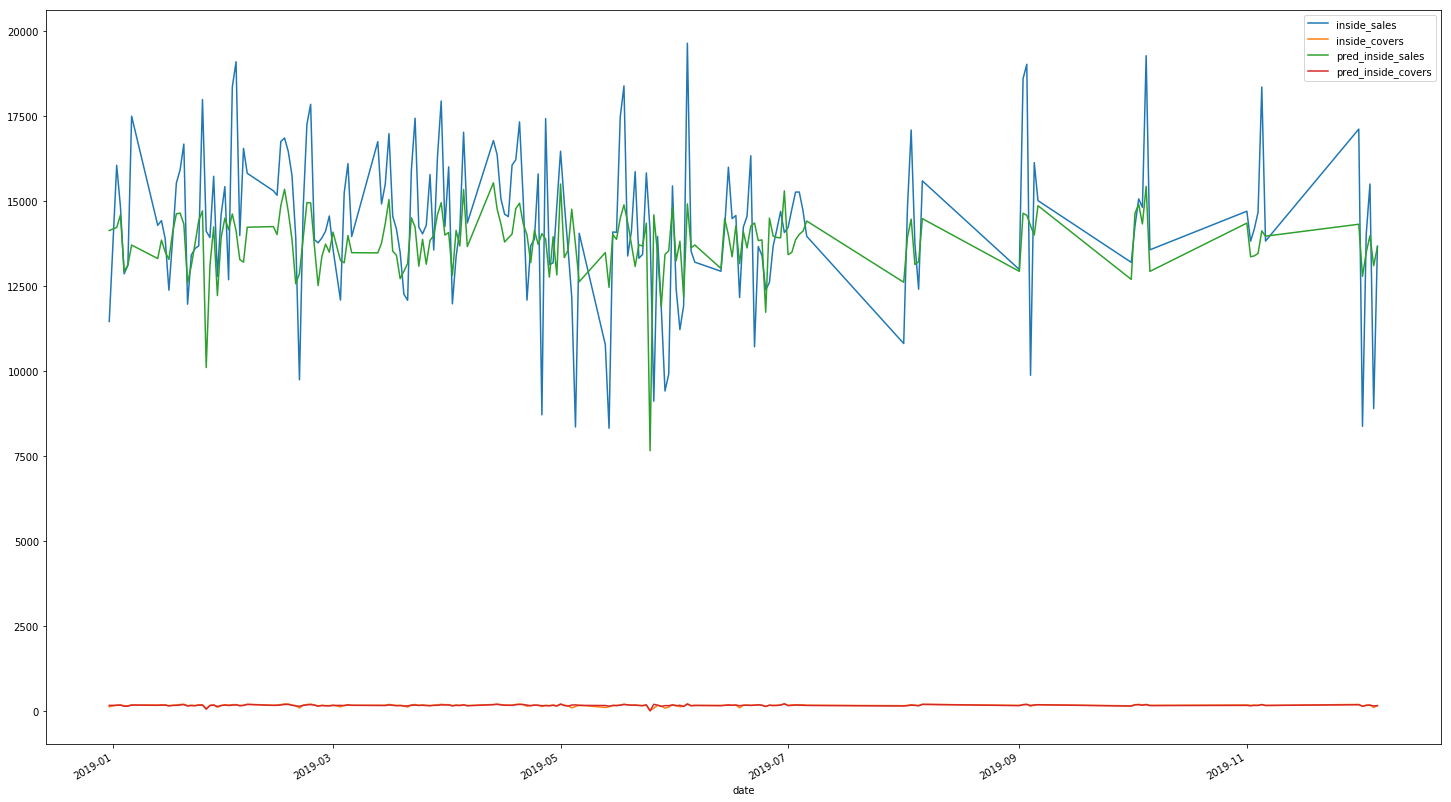

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       14132.331172   
2019-02-01      12685.24            183       14156.255070   
2019-03-01      13580.96            184       14085.158033   
2019-04-01      16002.75            197       14073.922738   
2019-05-01      16463.62            216       15500.470650   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          175.008846         2674.331172            43.008846  
2019-02-01          171.003802         1471.015070           -11.996198  
2019-03-01          171.816498          504.198033           -12.183502  
2019-04-01          187.992387        -1928.827262            -9.007613  
2019-05-01          208.379023         -963.149350            -7.620977  
Linear Regression for sales data with weather: 

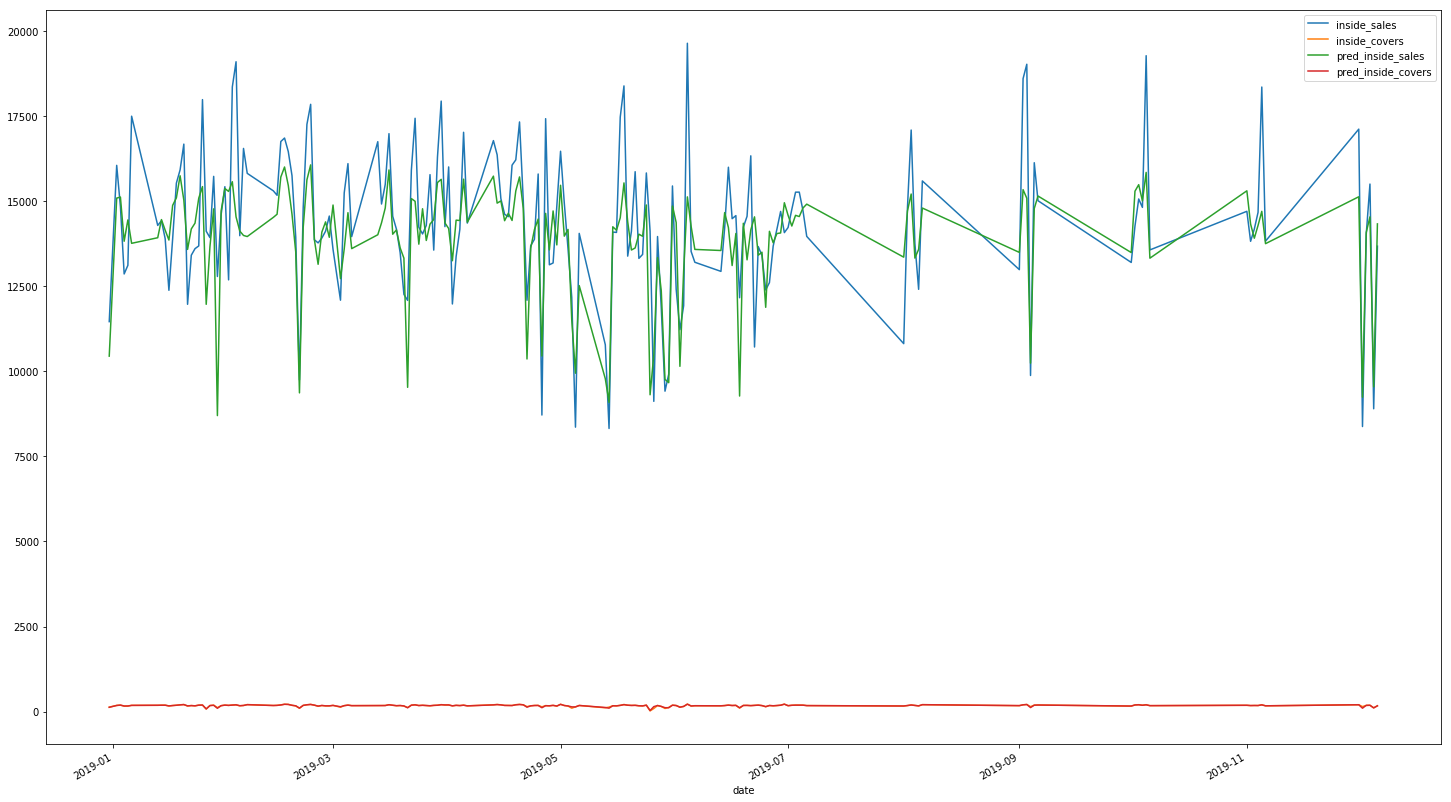

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       10444.213193   
2019-02-01      12685.24            183       15283.467406   
2019-03-01      13580.96            184       14883.793591   
2019-04-01      16002.75            197       14193.256701   
2019-05-01      16463.62            216       15463.699364   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          127.043521        -1013.786807            -4.956479  
2019-02-01          184.034524         2598.227406             1.034524  
2019-03-01          182.514104         1302.833591            -1.485896  
2019-04-01          196.317860        -1809.493299            -0.682140  
2019-05-01          214.032143         -999.920636            -1.967857  


In [18]:
def linear_regression(x_train,y_train,x_test,y_test):
    lr= LinearRegression()
    liner_rgr = lr.fit(x_train,y_train)
    pred = score(lr, x_train, y_train, x_test, y_test)
    return pred
print("Linear Regression for sales data without weather: ")
x_train_sal,y_train_sal,x_test_sal,y_test_sal = data_split(x_sal,y_sal)
linear_regression(x_train_sal,y_train_sal,x_test_sal,y_test_sal)

if len(weather_fea) > 0:
    print("Linear Regression for sales data with weather: ")
    
    x_train_wet,y_train_wet,x_test_wet,y_test_wet = data_split(x_wet,y_wet)
    linear_regression(x_train_wet,y_train_wet,x_test_wet,y_test_wet)


XGBRegressor for sales data without weather: 
Train set: 719 -> 79.98%
Test set: 180 -> 20.02%
Mean Absolute Error:  973.0064978623985
Root Mean Squared Error:  1812.1085136309825


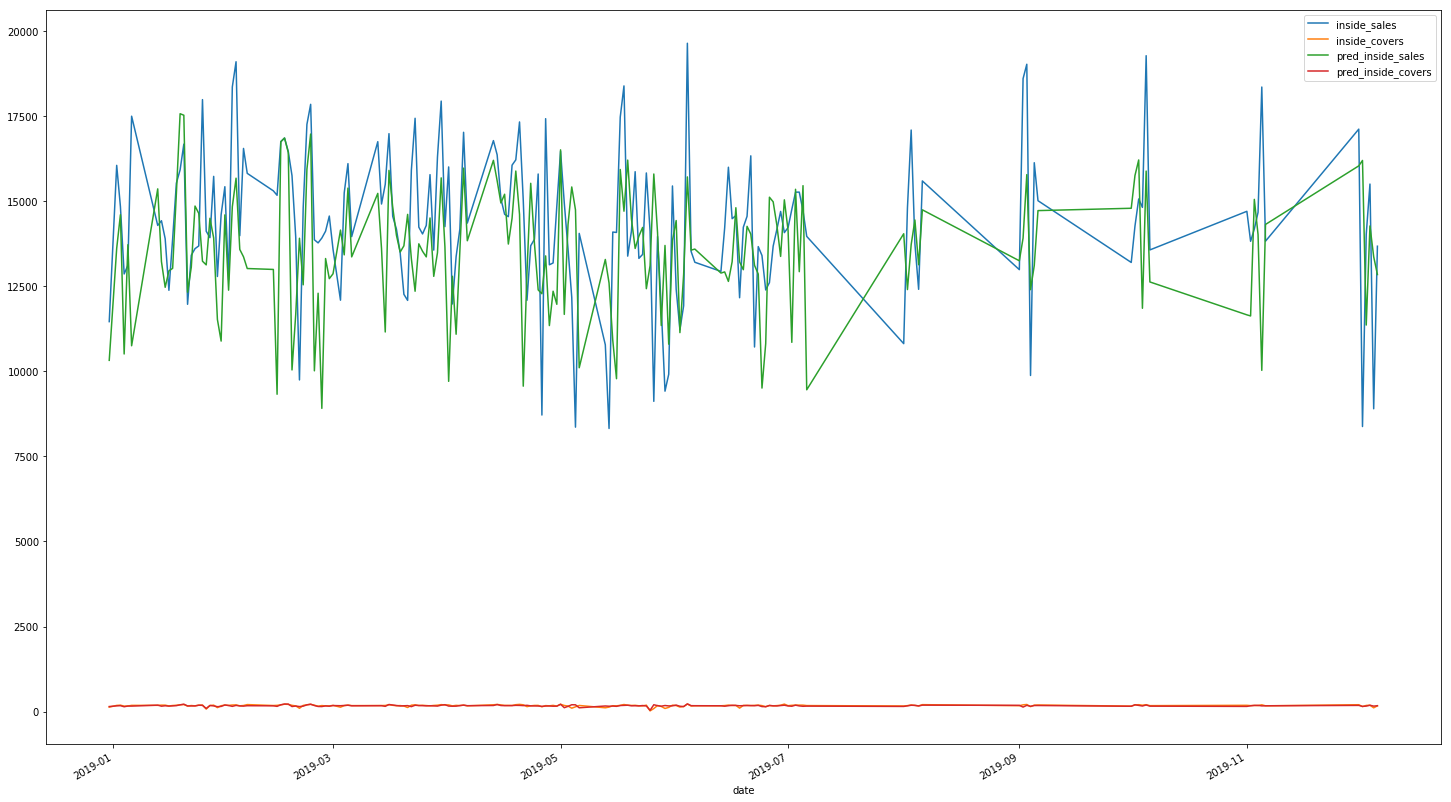

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       10320.646484   
2019-02-01      12685.24            183       12381.924805   
2019-03-01      13580.96            184       12863.963867   
2019-04-01      16002.75            197        9703.662109   
2019-05-01      16463.62            216       16505.048828   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          149.455994        -1137.353516            17.455994  
2019-02-01          179.528503         -303.315195            -3.471497  
2019-03-01          178.937592         -716.996133            -5.062408  
2019-04-01          163.469925        -6299.087891           -33.530075  
2019-05-01          216.782394           41.428828             0.782394  
XGBRegressor for sales data with weather: 
Trai

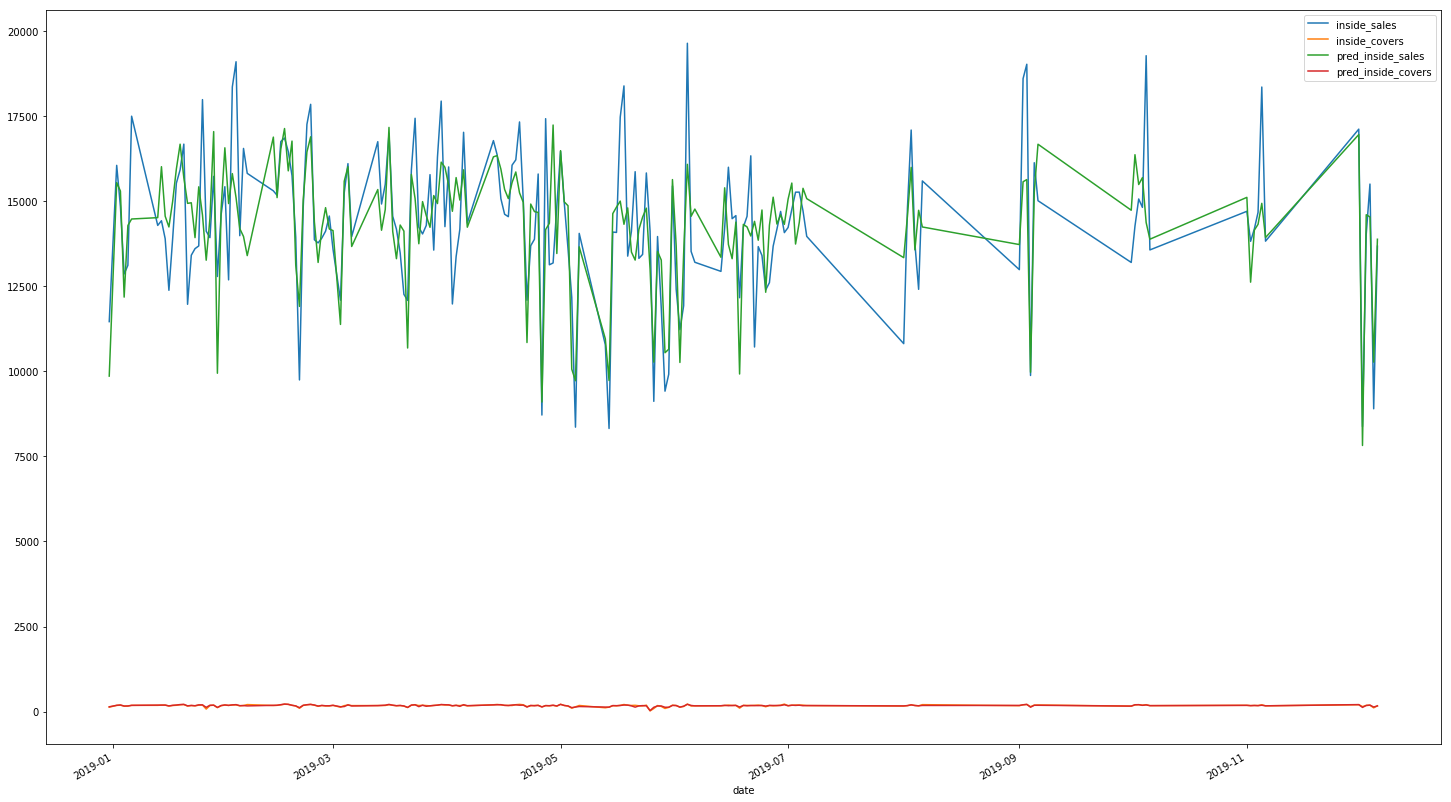

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132        9857.568359   
2019-02-01      12685.24            183       14926.993164   
2019-03-01      13580.96            184       14132.272461   
2019-04-01      16002.75            197       15468.740234   
2019-05-01      16463.62            216       16481.023438   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          141.870255        -1600.431641             9.870255  
2019-02-01          183.848587         2241.753164             0.848587  
2019-03-01          185.639236          551.312461             1.639236  
2019-04-01          198.070023         -534.009766             1.070023  
2019-05-01          213.818573           17.403438            -2.181427  


In [19]:
def xgboost(x_train,y_train,x_test,y_test):
    
    rgr = MultiOutputRegressor(XGBRegressor(booster='gbtree', objective='reg:squarederror', random_state = 0))
    grid = rgr.fit(x_train,y_train)
    pred = score(grid, x_train, y_train, x_test, y_test)
    return pred

print("XGBRegressor for sales data without weather: ")
x_train_sal,y_train_sal,x_test_sal,y_test_sal = data_split(x_sal,y_sal)
xgboost(x_train_sal,y_train_sal,x_test_sal,y_test_sal)

if len(weather_fea) > 0:
    print("XGBRegressor for sales data with weather: ")

    x_train_wet,y_train_wet,x_test_wet,y_test_wet = data_split(x_wet,y_wet)
    xgboost(x_train_wet,y_train_wet,x_test_wet,y_test_wet)

MLP Regressor for sales data without weather: 
Train set: 719 -> 79.98%
Test set: 180 -> 20.02%
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Grid Search:  MLPRegressor 

Grid Search Best Score:  -1814349.0028431998
Grid Search Best Params:  {'activation': 'relu', 'alpha': 0.0005, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}
Grid Search Best Estimator:  MLPRegressor(alpha=0.0005, hidden_layer_sizes=(10,), max_iter=8000,
             solver='lbfgs')
Mean Absolute Error:  693.265402959889
Root Mean Squared Error:  1378.2936987159871


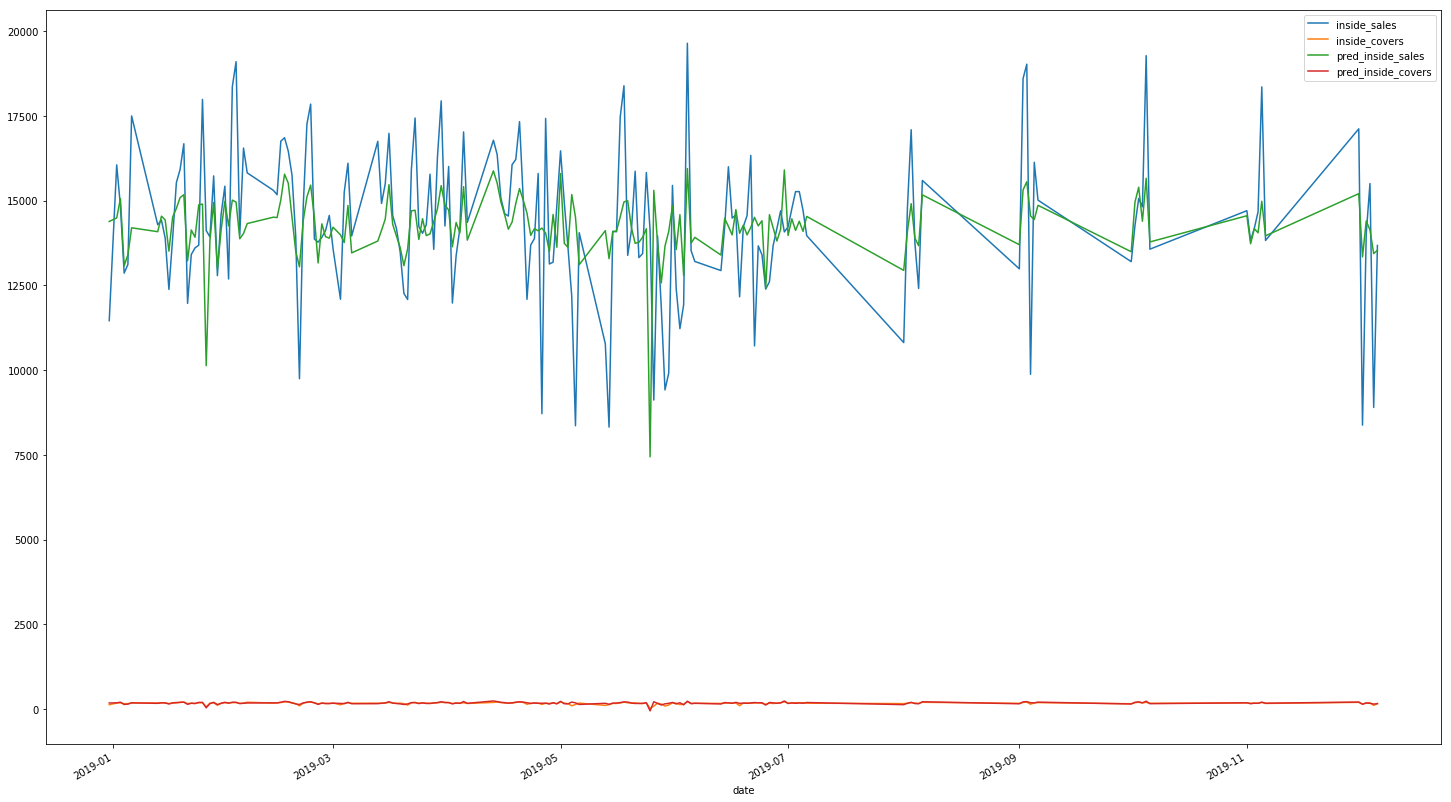

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       14382.125955   
2019-02-01      12685.24            183       14252.764851   
2019-03-01      13580.96            184       14213.500229   
2019-04-01      16002.75            197       14720.061449   
2019-05-01      16463.62            216       15794.643628   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          184.481620         2924.125955            52.481620  
2019-02-01          179.569369         1567.524851            -3.430631  
2019-03-01          178.116976          632.540229            -5.883024  
2019-04-01          195.174671        -1282.688551            -1.825329  
2019-05-01          231.848421         -668.976372            15.848421  
MLP Regressor for sales data with weather: 
Tra

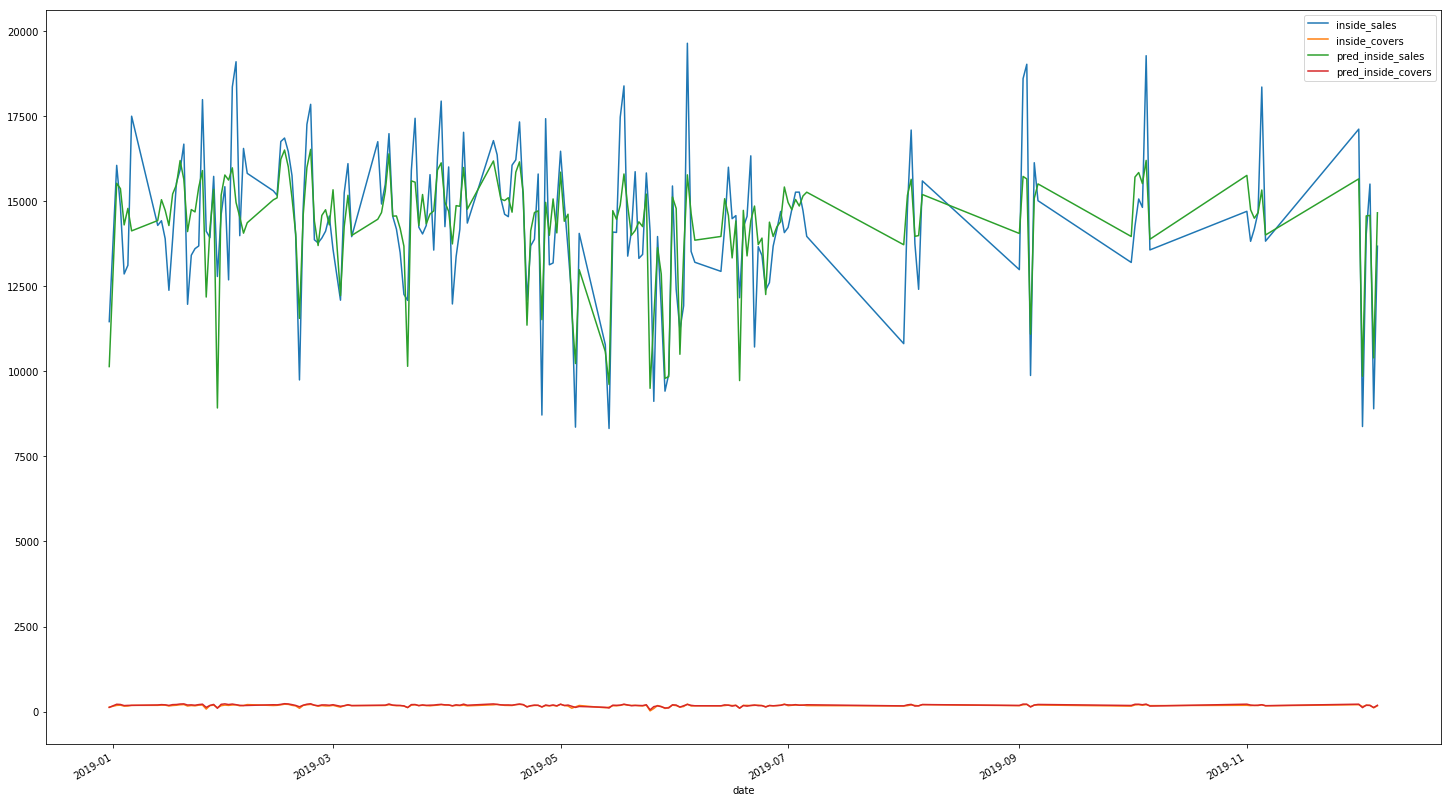

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       10137.501432   
2019-02-01      12685.24            183       15616.918085   
2019-03-01      13580.96            184       15332.153812   
2019-04-01      16002.75            197       14697.180846   
2019-05-01      16463.62            216       15848.755983   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          124.142449        -1320.498568            -7.857551  
2019-02-01          208.910867         2931.678085            25.910867  
2019-03-01          203.233529         1751.193812            19.233529  
2019-04-01          195.310432        -1305.569154            -1.689568  
2019-05-01          219.097215         -614.864017             3.097215  


In [20]:
def mlp_regg(x_train,y_train,x_test,y_test):
    param_list = {"hidden_layer_sizes": [(10,),(50,)], 
                  "activation": ["identity", "logistic", "tanh", "relu"], 
                  "solver": ["lbfgs", "sgd", "adam"], 
                  "alpha": [0.00005,0.0005]
                 }

    mlp = MLPRegressor(max_iter=8000,solver='sgd',alpha=0.0005)
    
    scoring = 'neg_mean_squared_error'
    grid_mlp = GridSearchCV(mlp, param_list, cv=5, n_jobs =-1, scoring = 'neg_mean_squared_error', verbose =5)
    grid_mlp = grid_mlp.fit(x_train, y_train)
    best_grid_mlp = grid_mlp.best_estimator_
    
    print('Grid Search: ', mlp.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid_mlp.best_score_)
    print('Grid Search Best Params: ', grid_mlp.best_params_)
    print('Grid Search Best Estimator: ', grid_mlp.best_estimator_)
    
    pred = score(best_grid_mlp, x_train, y_train, x_test, y_test)
    return pred

print("MLP Regressor for sales data without weather: ")
x_train_sal,y_train_sal,x_test_sal,y_test_sal = data_split(x_sal,y_sal)
mlp_regg(x_train_sal,y_train_sal,x_test_sal,y_test_sal)

if len(weather_fea) > 0:
    print("MLP Regressor for sales data with weather: ")
    
    x_train_wet,y_train_wet,x_test_wet,y_test_wet = data_split(x_wet,y_wet)
    mlp_regg(x_train_wet,y_train_wet,x_test_wet,y_test_wet)

svr for sales data without weather: 
Train set: 719 -> 79.98%
Test set: 180 -> 20.02%
Mean Absolute Error:  645.9148649358555
Root Mean Squared Error:  1394.3888642932347


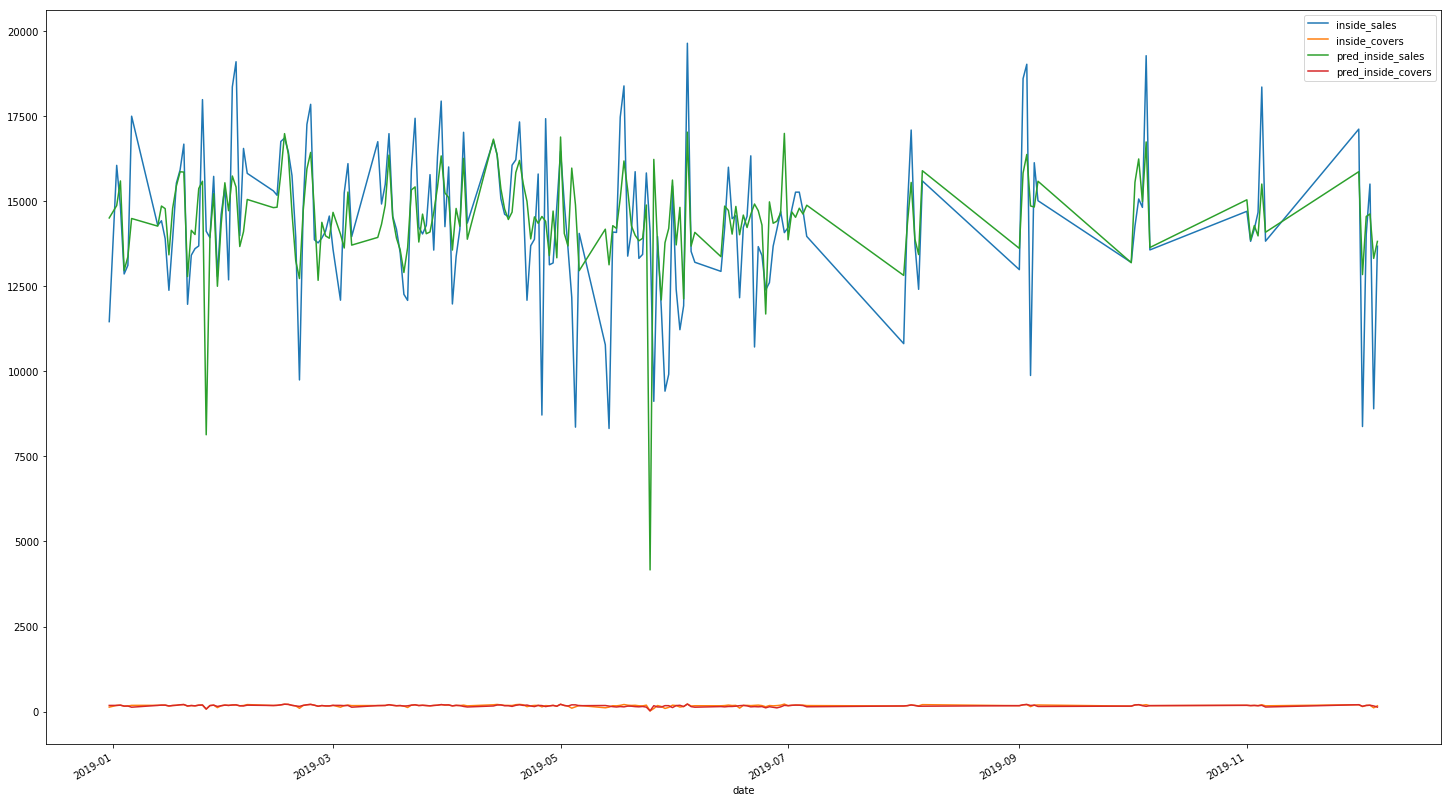

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       14504.021168   
2019-02-01      12685.24            183       14717.448969   
2019-03-01      13580.96            184       14668.510725   
2019-04-01      16002.75            197       15103.394717   
2019-05-01      16463.62            216       16881.394698   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          181.990023         3046.021168            49.990023  
2019-02-01          182.990018         2032.208969            -0.009982  
2019-03-01          183.990018         1087.550725            -0.009982  
2019-04-01          196.990019         -899.355283            -0.009981  
2019-05-01          215.990026          417.774698            -0.009974  
svr for sales data with weather: 
Train set: 71

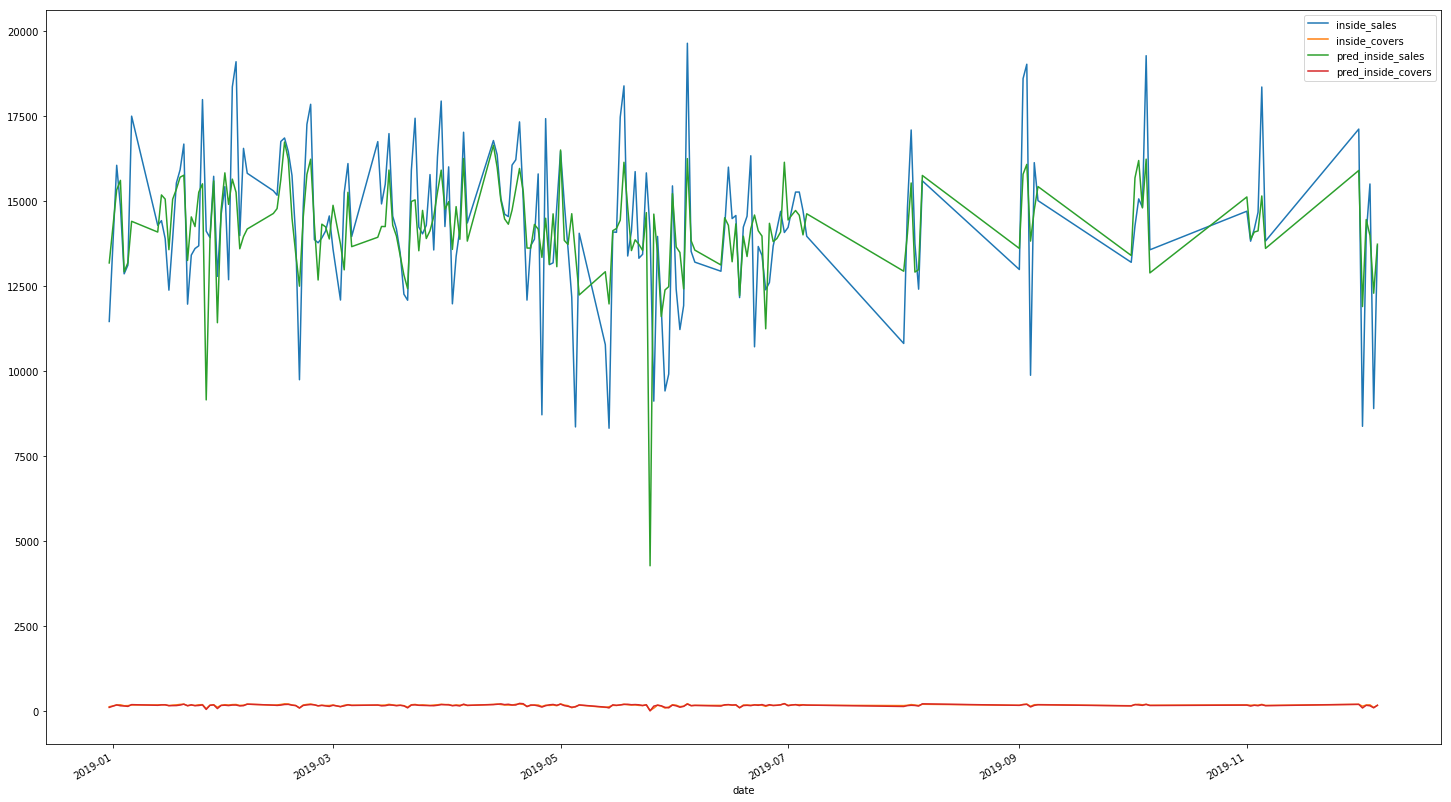

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       13178.301570   
2019-02-01      12685.24            183       14900.356655   
2019-03-01      13580.96            184       14872.784519   
2019-04-01      16002.75            197       14980.458204   
2019-05-01      16463.62            216       16498.531210   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          112.800433         1720.301570           -19.199567  
2019-02-01          166.240281         2215.116655           -16.759719  
2019-03-01          174.745706         1291.824519            -9.254294  
2019-04-01          187.150341        -1022.291796            -9.849659  
2019-05-01          208.707889           34.911210            -7.292111  


In [23]:
def svr(x_train,y_train,x_test,y_test):
    svrm =  MultiOutputRegressor(SVR(C=10, epsilon=0.01,kernel='linear'))
    svrm.fit(x_train, y_train)
    
    pred = score(svrm, x_train, y_train, x_test, y_test)
    return pred

print("svr for sales data without weather: ")
x_train_sal,y_train_sal,x_test_sal,y_test_sal = data_split(x_sal,y_sal)
svr(x_train_sal,y_train_sal,x_test_sal,y_test_sal)

print("svr for sales data with weather: ")

x_train_wet,y_train_wet,x_test_wet,y_test_wet = data_split(x_wet,y_wet)
svr(x_train_wet,y_train_wet,x_test_wet,y_test_wet)

Bayesian Ridge for sales data without weather: 
Train set: 719 -> 79.98%
Test set: 180 -> 20.02%
Mean Absolute Error:  691.5756305608297
Root Mean Squared Error:  1374.7735270402661


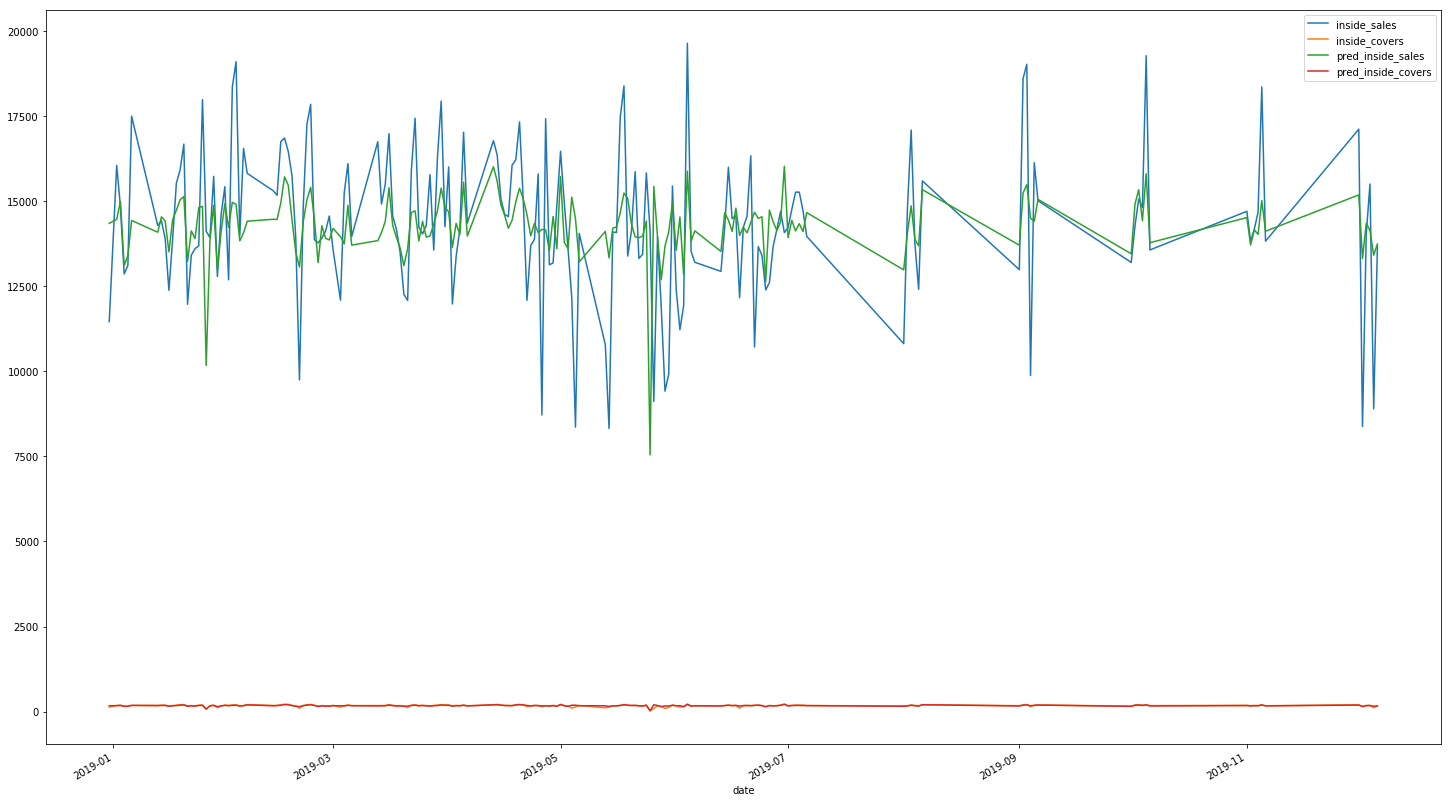

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       14346.034886   
2019-02-01      12685.24            183       14226.569554   
2019-03-01      13580.96            184       14197.080657   
2019-04-01      16002.75            197       14685.745821   
2019-05-01      16463.62            216       15717.705235   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          173.593708         2888.034886            41.593708  
2019-02-01          173.475091         1541.329554            -9.524909  
2019-03-01          174.252049          616.120657            -9.747951  
2019-04-01          186.582709        -1317.004179           -10.417291  
2019-05-01          204.878790         -745.914765           -11.121210  
Bayesian Ridge for sales data with weather: 
Tr

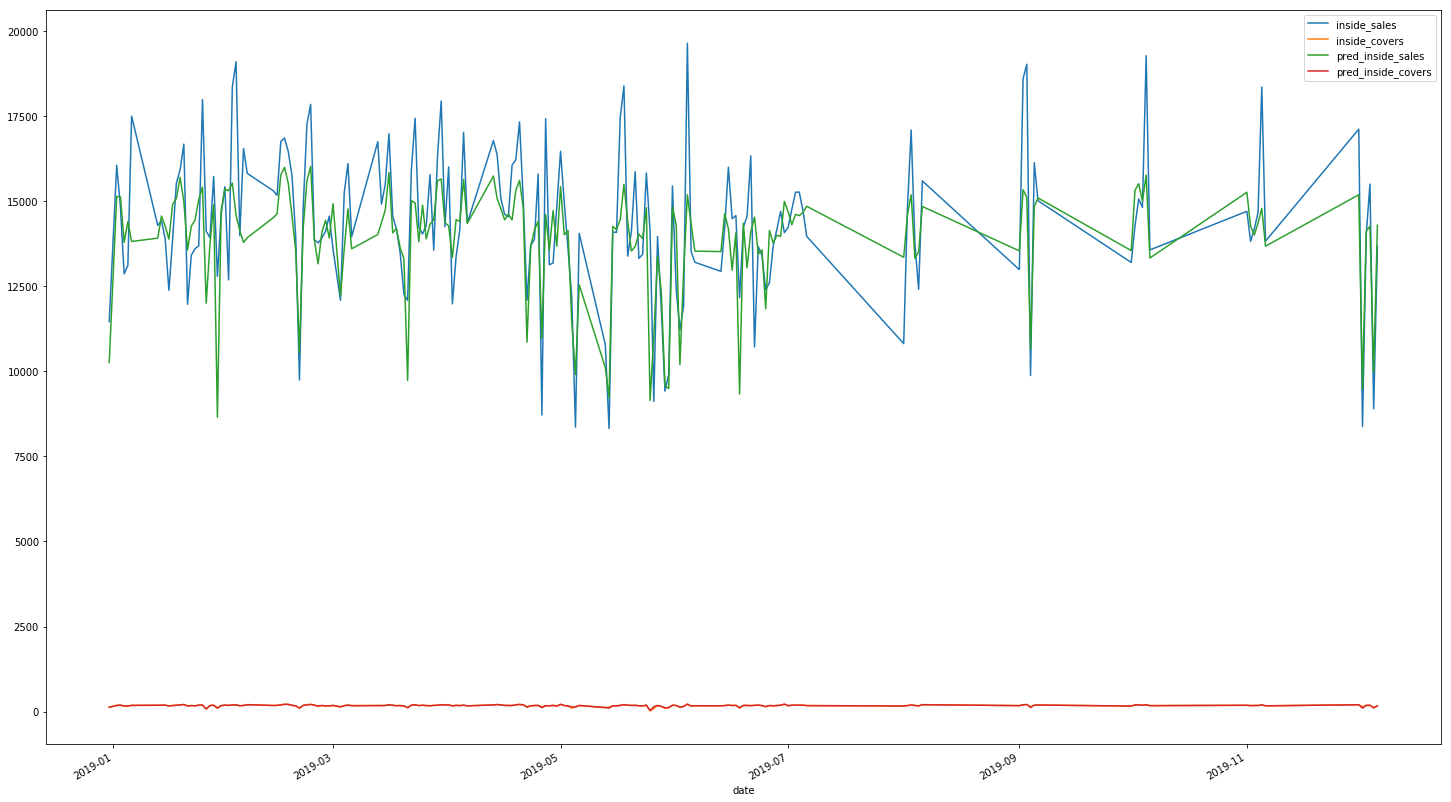

            inside_sales  inside_covers  pred_inside_sales  \
date                                                         
2018-12-31      11458.00            132       10258.868316   
2019-02-01      12685.24            183       15302.073850   
2019-03-01      13580.96            184       14924.640726   
2019-04-01      16002.75            197       14272.407412   
2019-05-01      16463.62            216       15424.158949   

            pred_inside_covers  Error_inside_sales  Error_inside_covers  
date                                                                     
2018-12-31          126.440292        -1199.131684            -5.559708  
2019-02-01          184.083100         2616.833850             1.083100  
2019-03-01          182.490370         1343.680726            -1.509630  
2019-04-01          196.256932        -1730.342588            -0.743068  
2019-05-01          213.833697        -1039.461051            -2.166303  


In [22]:
def lnr_model(x_train,y_train,x_test,y_test):
    clf = MultiOutputRegressor(linear_model.BayesianRidge())
    clf.fit(x_train, y_train)
    
    pred = score(clf,x_train,y_train,x_test,y_test)
    return pred

print("Bayesian Ridge for sales data without weather: ")
x_train_sal,y_train_sal,x_test_sal,y_test_sal = data_split(x_sal,y_sal)
lnr_model(x_train_sal,y_train_sal,x_test_sal,y_test_sal)

if len(weather_fea) > 0:
    print("Bayesian Ridge for sales data with weather: ")
    
    x_train_wet,y_train_wet,x_test_wet,y_test_wet = data_split(x_wet,y_wet)
    lnr_model(x_train_wet,y_train_wet,x_test_wet,y_test_wet)